# Lag-Llama: Towards Foundation Models for Probabilistic Time Series Forecasting


# Prepare the repository

In [ ]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

In [24]:
! cd /content/lag-llama

In [ ]:
!pip install -r requirements.txt --quiet

In [ ]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

In [ ]:
!pip install lightning

In [ ]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

# Lag-Llama prediction function

We create a function for Lag-Llama inference that we can reuse for all different types of dataset below. This function returns the predictions for the given prediction horizon. The forecast will be of shape (`num_samples`, `prediction_length`), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.


In [7]:
def get_lag_llama_predictions(dataset, prediction_length, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cuda:0')) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32, # Should not be changed; this is what the released Lag-Llama model was trained with

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        batch_size=1,
        num_parallel_samples=100
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

# Loading datasets of different types

We expand upon how one can support loading data stored in different formats. This part of the demo uses the tutorial by the authors of GluonTS at https://ts.gluon.ai/stable/tutorials/data_manipulation/pandasdataframes.html. We thank the authors of GluonTS for putting together such a detailed tutorial.

## Important Points to Note

1. The prediction function provided in this notebook performs a prediction autoregressively for the last `prediction_length` steps in the dataset passed.

For the time being, if you would like to perform prediction, please include in the CSV/dataframe the timestamps you want to perform prediction for (with a dummy value), and set the prediction length to the required horizon.

2. Please keep in mind that Lag-Llama needs a minimum context of `32` timestamps before the prediction timestamp starts. Beyond the `32` timestamps, Lag-Llama can use a context of upto `1092` more timestamps in history for the lags - this part is optional but you will find that as you give more context upto `(32+) 1092` timestamps, Lag-Llama's performance will improve.

The context length passed below should not be changed and kept at 32 nevertheless. Lag-Llama will automatically use context beyond 32 for the lags, if available.


## 3. Loading data from a wide dataframe

Here, we are given data in the `wide` format, where time series are stacked side-by-side in a `DataFrame`. We can simply turn this into a dictionary of `Series` objects with dict, and construct a `PandasDataset` with it.


### Load the dataset

In [30]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset

df_wide = pd.read_csv("/content/Raw_data_1Day_2022_site_117_ITO_Delhi_CPCB_1Day.csv", index_col=0, parse_dates=True)
df_wide = df_wide.iloc[-110:,:6] # we take the last 110 days and make prediction on the last 10 days
df_wide.head()

,PM2.5 (µg/m³),PM10 (µg/m³),NO (µg/m³),NO2 (µg/m³),NOx (ppb),NH3 (µg/m³)
Timestamp,,,,,,
2022-09-13,22.46,46.34,18.10,49.44,40.91,32.89
2022-09-14,23.32,46.96,17.72,47.41,39.54,33.20
2022-09-15,21.68,33.99,18.35,49.53,41.14,33.00
2022-09-16,22.83,36.20,16.34,43.03,36.00,28.64
2022-09-17,43.62,89.28,11.43,18.88,19.15,20.36


In [25]:
# Convert numerical columns to float 32 format for lag-llama
for col in df_wide.columns:
    # Check if column is not of string type
    if df_wide[col].dtype != 'object' and pd.api.types.is_string_dtype(df_wide[col]) == False:
        df_wide[col] = df_wide[col].astype('float32')

# Create a PandasDataset
ds = PandasDataset(dict(df_wide))

backtest_dataset = ds
prediction_length = 10  # Define your prediction length
num_samples = 100 # number of samples sampled from the probability distribution for each timestep

### Get predictions

We perform zero-shot inference.

In [31]:
# forecasts is a list of size num_series where num_series is the number of time series in the dataset.
# The samples can be accessed with the .samples object from each forecast.
# tss is the ground truth time series, which is useful to visualize when plotting.

forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, num_samples)

In [27]:
len(forecasts)

6

In [28]:
forecasts[0].samples.shape

(100, 10)

We plot the forecasts of our model on this dataset.

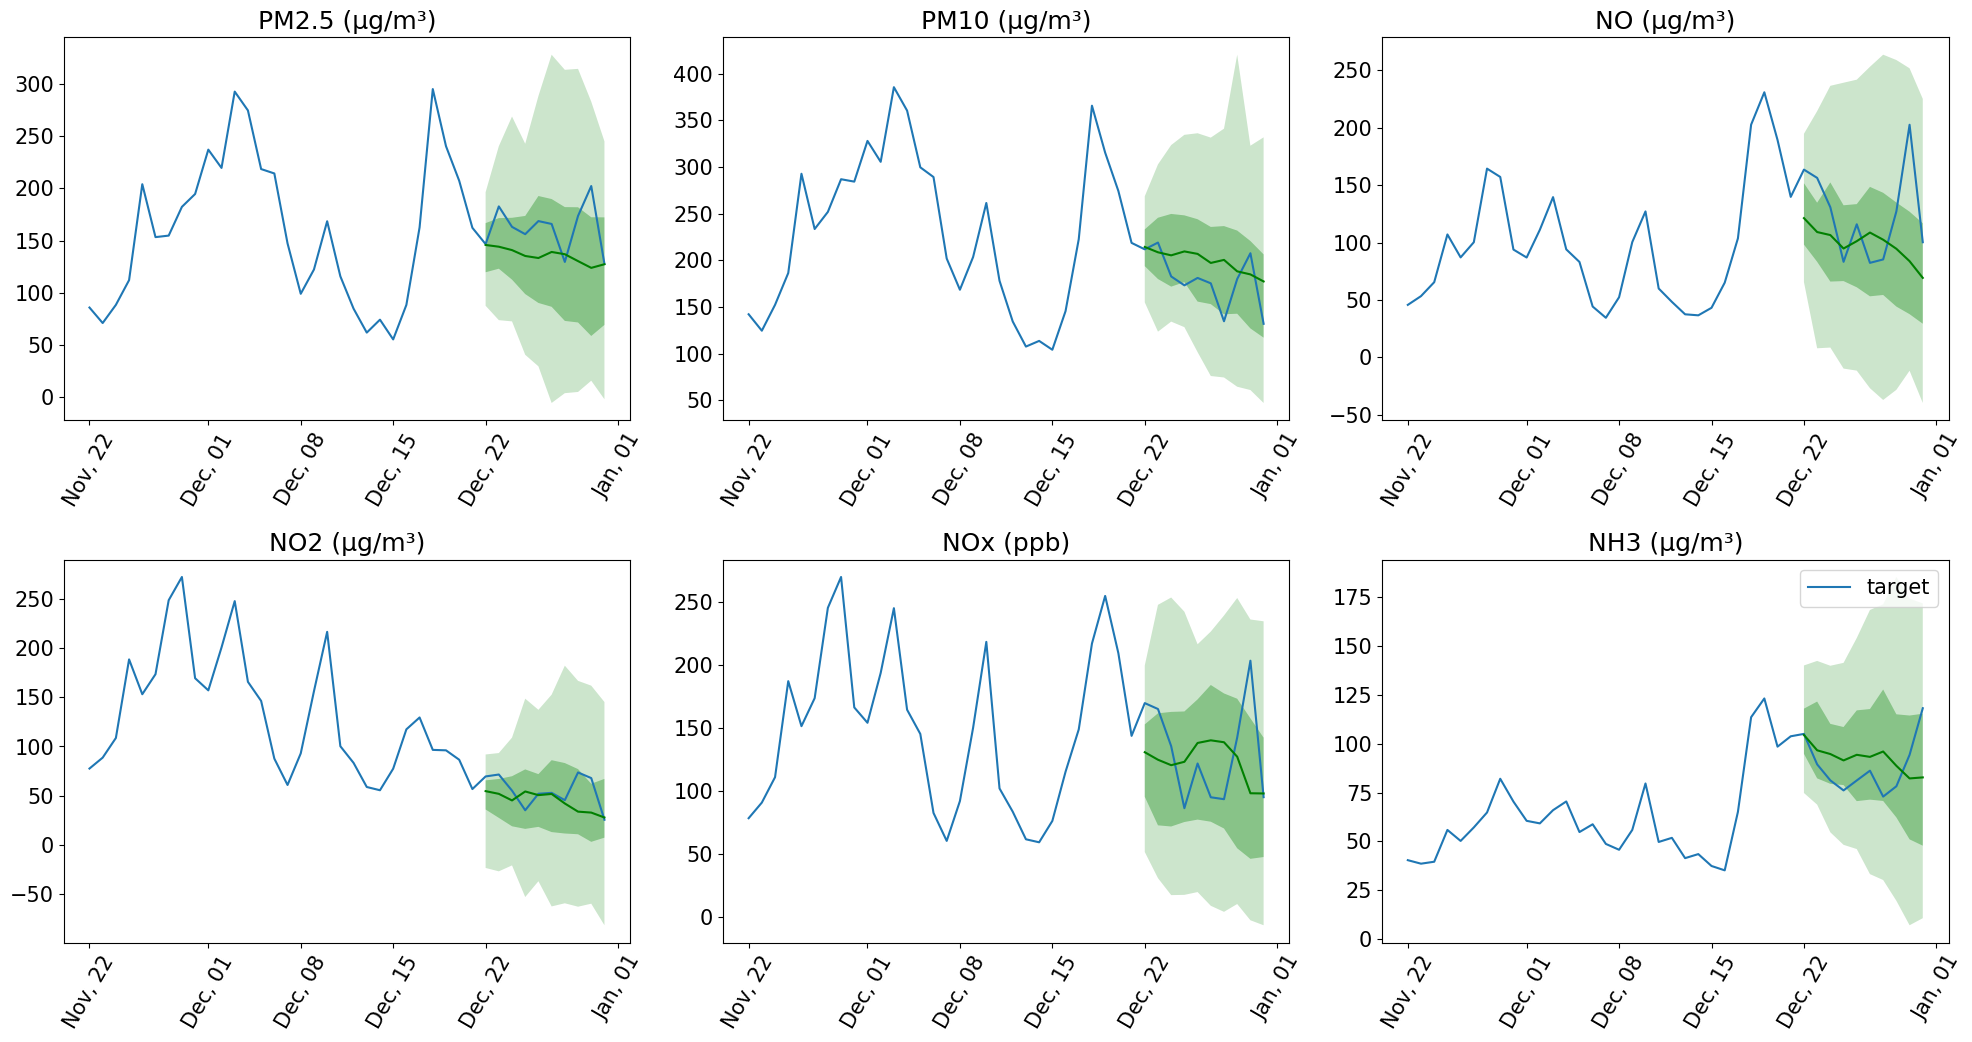

In [29]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()